# Splitting Datasets for Validation and Testing

A common problem with machine learning (ML) models is that they can very easily "overfit" the training data. This 
means that the model predicts the response values for training set compounds with perfect accuracy, but fails miserably on 
molecules that differ from the training compounds. To avoid overfitting and provide a way to test a model's ability
to generalize to new molecules, ML researchers have developed a variety of data splitting and training schemes.
**[AMPL](https://github.com/ATOMScience-org/AMPL)** supports two of the most popular strategies:
- 3-way training/validation/test splits 
- _k_-fold cross-validation

In this tutorial we will perform a 3-way split of the curated dataset we prepared in **Tutorial 1, "Data Curation"**, using the
**[AMPL](https://github.com/ATOMScience-org/AMPL)** modules, classes and functions listed below. _k_-fold cross-validation will be addressed in a future tutorial.

- [parameter_parser](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline-parameter-parser-module)
- [ModelPipeline](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.ModelPipeline)
- [split_dataset](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.ModelPipeline.split_dataset)
- [compare_splits_plots](https://ampl.readthedocs.io/en/latest/utils.html#module-utils.compare_splits_plots)
- [split_response_dist_plots](https://ampl.readthedocs.io/en/latest/utils.html#module-utils.split_response_dist_plots)

With 3-way data splitting, you divide your curated dataset into three subsets:

|Subset|Description|
|---|---|
| **Training set**| Usually the largest subset. **[AMPL](https://github.com/ATOMScience-org/AMPL)** feeds the training set compound features and response values in batches to the model fitting algorithm. The fitting algorithm iteratively adjusts the model parameters after each batch so that the predicted responses are close (on average) to the actual response values.|
| **Validation set** | Used after training a collection of models to see how well each one performs on "new" compounds that weren't used directly to fit the model parameters, so you can choose the best model. The validation set is also used by **[AMPL](https://github.com/ATOMScience-org/AMPL)** during **neural network model** training to implement "early stopping", a trick to avoid overfitting the training set.|
| **Test set** | After training is completed, **[AMPL](https://github.com/ATOMScience-org/AMPL)** scores the predictions on the test set compounds to provide a measure of the final model's performance.|

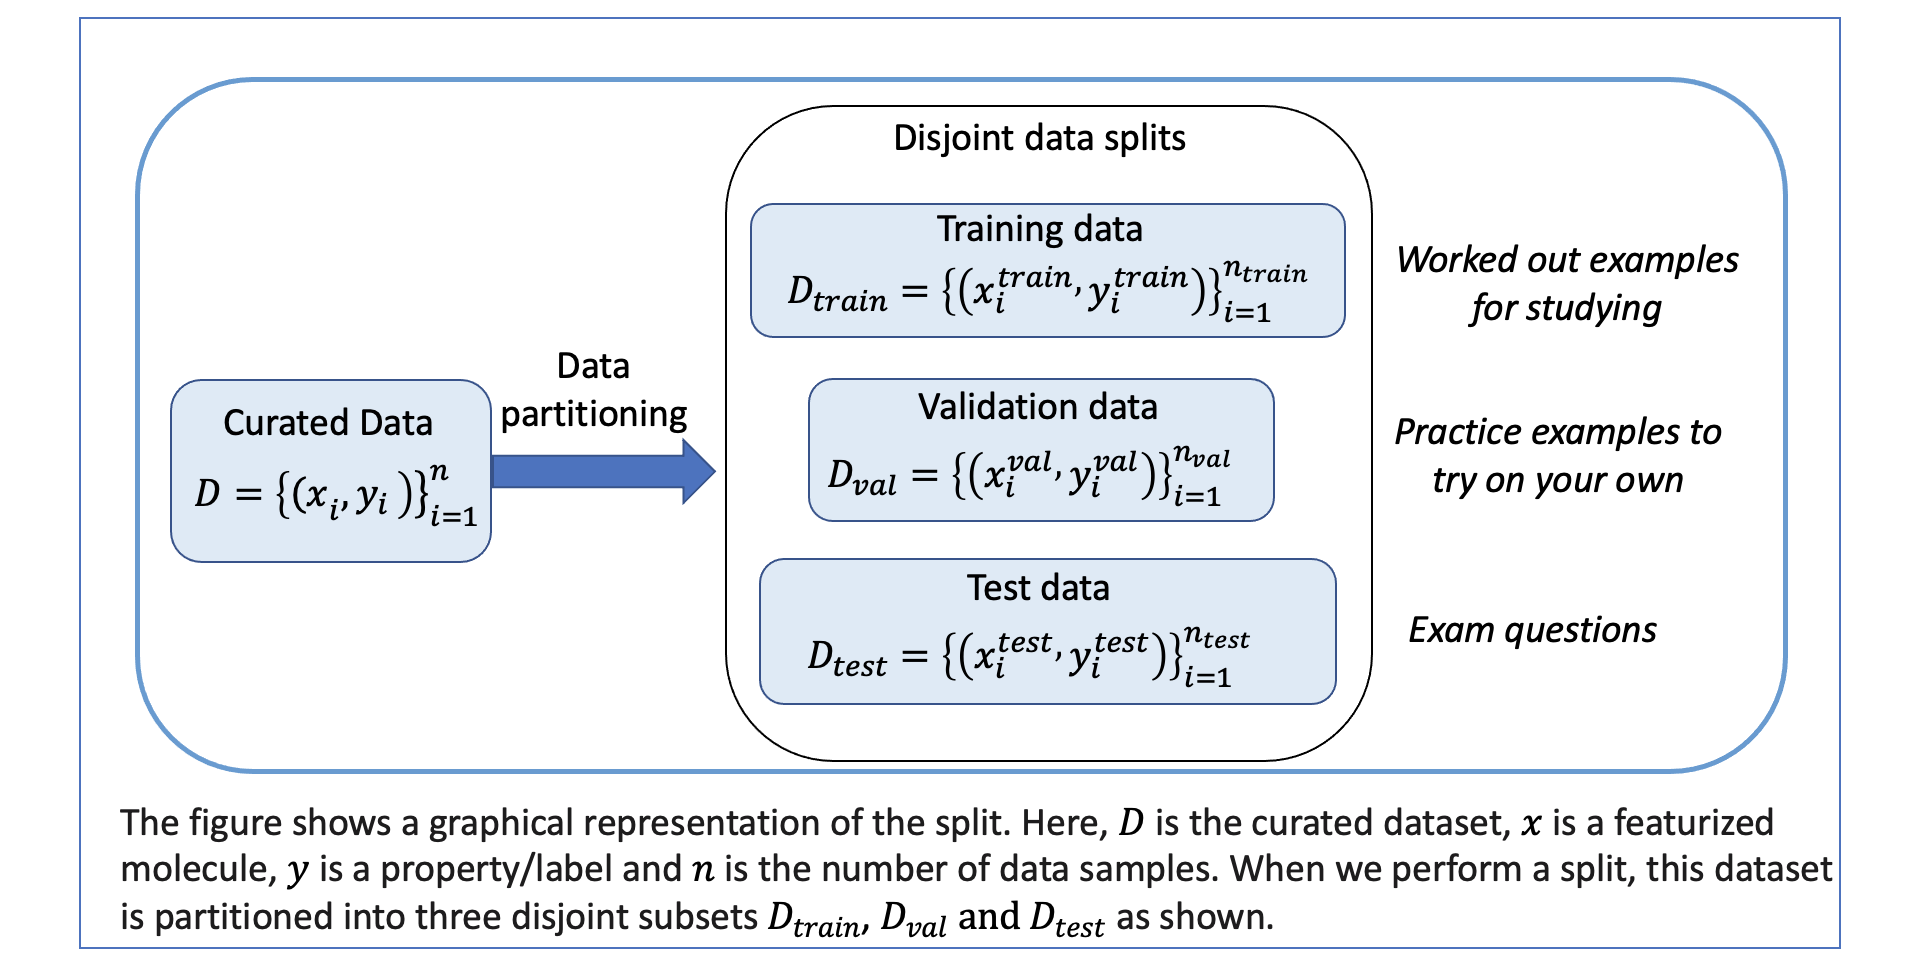


In [1]:
import pandas as pd

# Set up
dataset_file = 'dataset/SLC6A3_Ki_curated.csv'
odir = 'dataset'

# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

## Splitting Methods

**[AMPL](https://github.com/ATOMScience-org/AMPL)** supports a variety of splitting algorithms, including **random** and **scaffold splits**. A **scaffold** is the
core structure of a molecule, with its side chains removed. **Scaffold splits** assign molecules to the training, validation and test sets, so that molecules with the same scaffold group together in the same subset. 
This ensures that compounds in the validation and test sets have different scaffolds from those in the 
training set, and are thus more likely to be structurally different. By contrast, a random split assigns molecules to subsets randomly.

### Rationale for Using Scaffold vs Random Splits

A **scaffold split** is more challenging for model fitting than a **random split**. With a random split, many 
test set compounds may be similar to molecules in the training set, so a model may _appear_ to perform well 
when it is simply "memorizing" training compound structures
associated with different response levels. Such a model will perform badly on molecules that truly are 
different from the training compounds. However, a model trained on molecules that belong to a limited set of scaffold classes has to learn combinations of features that generalize across many chemical families 
to make accurate predictions on compounds with novel scaffolds. A scaffold split provides a way to select 
models with greater generalization ability and assess their performance realistically.


## Performing a Split
We start by constructing a dictionary of parameter values:

In [2]:
params = {
    # dataset info
    "dataset_key" : dataset_file,
    "response_cols" : "avg_pKi",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": odir,

    # splitting
    "previously_split": "False",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}


We parse the `params` dict with the `parameter_parser` module to create a parameter object for input to **[AMPL](https://github.com/ATOMScience-org/AMPL)** functions.

We then create a `ModelPipeline` object and call its `split_dataset` method to do the actual split.

> **Note**: 
             `split_dataset()` can also featurize the dataset; we will explore featurization in a later tutorial. For now, we provide prefeaturized data in the `./dataset/scaled_descriptors` folder. 

In [3]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
split_uuid = MP.split_dataset()

2024-06-25 08:49:14.724215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 08:49:14.724277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 08:49:14.736868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 08:49:16.903196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 08:49:37.972723: W tensorflow/compiler/

The dataset split table is saved as a .csv in the same directory as the `dataset_key`. 
The name of the split file starts with the `dataset_key` and is followed by the `split_strategy` (train_valid_test), `split type` (scaffold), and the `split_uuid` (a unique identifier of the split).

In [4]:
# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{split_uuid}*")[0]
split_file

'dataset/SLC6A3_Ki_curated_train_valid_test_scaffold_640d807b-f58a-47f3-913d-4a60db0a9dbd.csv'

## Format of the Split File
The split file consists of three columns: `cmpd_id` is the compound ID; `subset` tells you if the compound is in the train, validation, or test set and `fold` contains the fold index, which is used only by _k_-fold cross-validation splits.

In [5]:
# Explore contents of the split file
split_df = pd.read_csv(split_file)
split_df.head()

,cmpd_id,subset,fold
0,CHEMBL498564,train,0
1,CHEMBL1085567,train,0
2,CHEMBL236473,train,0
3,CHEMBL464422,train,0
4,CHEMBL611677,train,0


In [6]:
# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

subset
train    1273
valid     273
test      273
Name: count, dtype: int64

## Visualizing Scaffold Splits
**[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance)** is a handy way 
to measure structural dissimilarity between compounds represented using **[ECFP fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t)**. 

We can use functions in the `compare_splits_plots` module to compute **[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance)** between each validation and
test set compound and its nearest neighbor in the training set, and then plot the distribution of distances for 
each subset. 

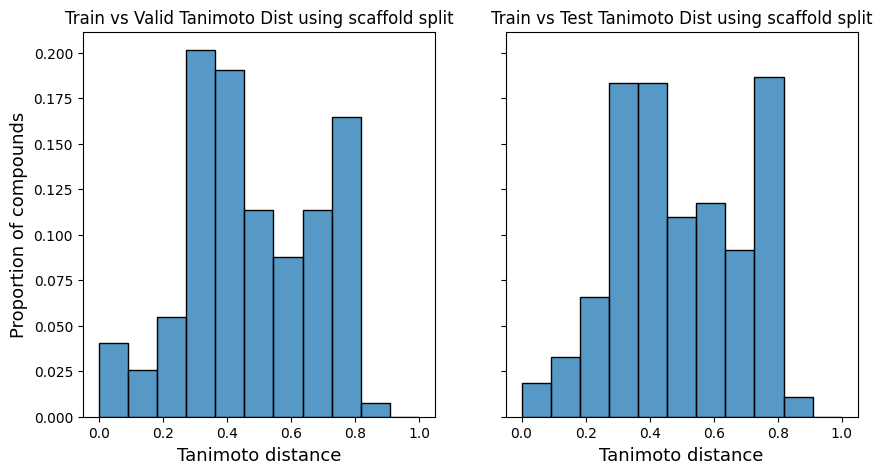

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv('dataset/SLC6A3_Ki_curated.csv')

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=['avg_pKi'])

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {split_type} split");

The majority of compounds have **[Tanimoto distances](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance)** between 0.2 and 0.8 from the training set, indicating that they are structurally different from the training compounds. The distance distributions are similar between the test and validation sets. This indicates that a model selected based on its validation set performance will
likely have similar performance when evaluated on the test set.

We can also plot the distributions of the response values - the $pK_i$'s - in each subset. These plots can
be useful in diagnosing model performance problems; if the response distributions in the training and test sets
are dramatically different, it may be hard to train a model that performs well on the test set.

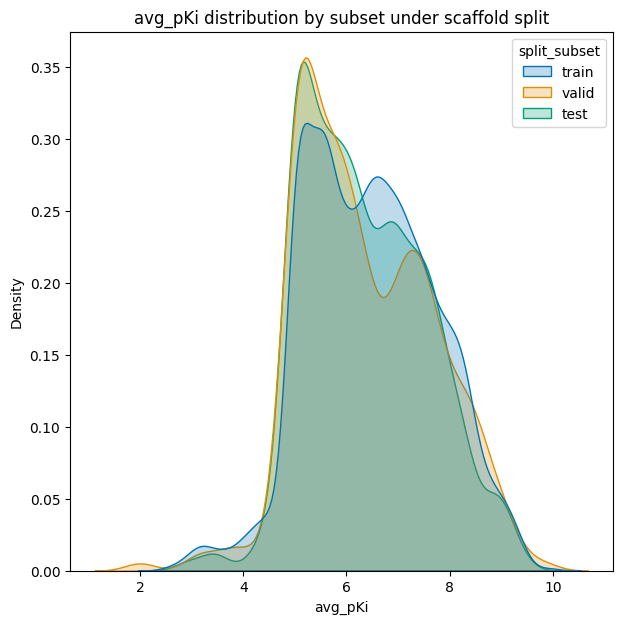

In [8]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "base_rdkit_smiles",
    "response_cols" : "avg_pKi",
    "split_uuid": split_uuid,
    "splitter": 'scaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

For this dataset, the $pK_i$'s have roughly similar distributions across the **scaffold split** subsets, except that the training set has slightly more compounds with large values.

In **Tutorial 3, "Train a Simple Regression Model"**, we will use this dataset and **scaffold split** to train a model to predict the $pK_i$'s.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.